In [2]:
"https://johnunwin.medium.com/using-tensorflow-and-keras-to-predict-house-prices-696bc7902ef0"

'https://johnunwin.medium.com/using-tensorflow-and-keras-to-predict-house-prices-696bc7902ef0'

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
import numpy as np
import pydot
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
data= pd.read_csv('house_properties_data_processed.csv')

In [5]:
data.drop(columns='adress', inplace=True,axis=1)

# Scale the values in the dataframe

train, test = train_test_split(data, test_size=0.2)
train, validation = train_test_split(train,test_size=0.2)

In [6]:
data_features = train.copy()

data_scaling = max(data['sold_price'])
data_labels = data_features.pop('sold_price')/ data_scaling

validation_features = validation.copy()
validation_labels = validation.pop('sold_price')/ data_scaling

In [7]:
inputs = {name: tf.keras.layers.Input(shape=(1,), name=name) for name in data_features.keys()}

In [8]:
inputs

{'longitude': <tf.Tensor 'longitude:0' shape=(None, 1) dtype=float32>,
 'latitude': <tf.Tensor 'latitude:0' shape=(None, 1) dtype=float32>,
 'living_area': <tf.Tensor 'living_area:0' shape=(None, 1) dtype=float32>,
 'land_area': <tf.Tensor 'land_area:0' shape=(None, 1) dtype=float32>,
 'supplemental_area': <tf.Tensor 'supplemental_area:0' shape=(None, 1) dtype=float32>,
 'patio': <tf.Tensor 'patio:0' shape=(None, 1) dtype=float32>,
 'balcony': <tf.Tensor 'balcony:0' shape=(None, 1) dtype=float32>,
 'number_of_rooms': <tf.Tensor 'number_of_rooms:0' shape=(None, 1) dtype=float32>,
 'build_year': <tf.Tensor 'build_year:0' shape=(None, 1) dtype=float32>,
 'operating_cost': <tf.Tensor 'operating_cost:0' shape=(None, 1) dtype=float32>,
 'living_to_land_ratio': <tf.Tensor 'living_to_land_ratio:0' shape=(None, 1) dtype=float32>,
 'area_per_room': <tf.Tensor 'area_per_room:0' shape=(None, 1) dtype=float32>}

In [9]:
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype == tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<tf.Tensor 'normalization/truediv:0' shape=(None, 12) dtype=float32>

In [10]:
preprocessed_inputs = [all_numeric_inputs]

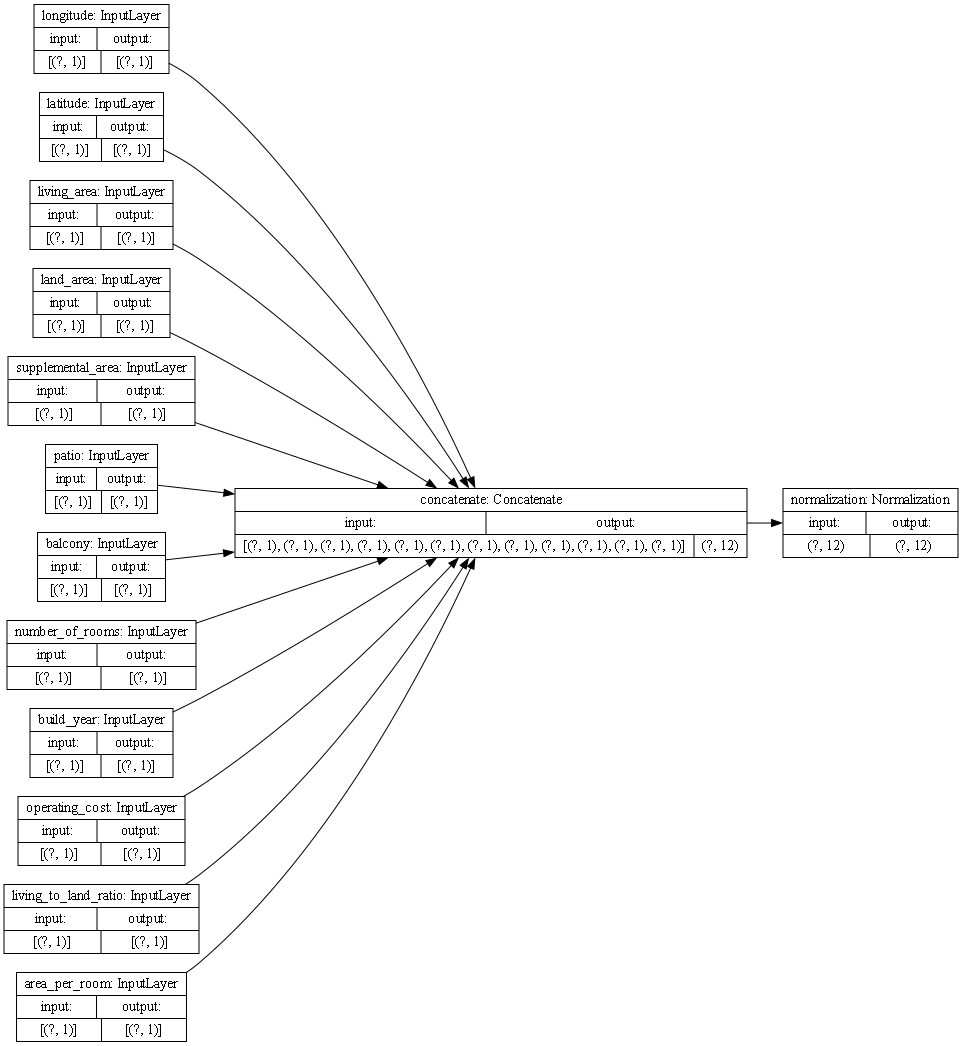

In [11]:
housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [12]:
data_features_dict = {name: np.array(value) 
                         for name, value in data_features.items()}

In [13]:
data_dict = {name:values[:1] for name, values in data_features_dict.items()}
housePrices_preprocessing(data_dict)

<tf.Tensor: shape=(1, 12), dtype=float32, numpy=
array([[ 1.5235857 ,  0.8639726 , -0.4997858 , -0.21300612,  1.3791882 ,
        -0.5721347 , -0.29567945,  0.6032517 ,  0.22453098, -1.5008165 ,
         0.29766953, -1.301167  ]], dtype=float32)>

In [14]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

In [15]:
validation_features_dict = {name: np.array(value) 
                         for name, value in validation.items()}
history_1 = housePrices_model.fit(x=data_features_dict, y=data_labels,epochs=250,
                        validation_data=(validation_features_dict, validation_labels))

Epoch 1/250
45/45 [==============================] - 0s 5ms/step - loss: 0.0449 - mae: 0.1033 - val_loss: 0.0299 - val_mae: 0.0690
Epoch 2/250
45/45 [==============================] - 0s 938us/step - loss: 0.0274 - mae: 0.0621 - val_loss: 0.0262 - val_mae: 0.0581
Epoch 3/250
45/45 [==============================] - 0s 2ms/step - loss: 0.0254 - mae: 0.0570 - val_loss: 0.0248 - val_mae: 0.0585
Epoch 4/250
45/45 [==============================] - 0s 1ms/step - loss: 0.0218 - mae: 0.0475 - val_loss: 0.0231 - val_mae: 0.0534
Epoch 5/250
45/45 [==============================] - 0s 849us/step - loss: 0.0200 - mae: 0.0442 - val_loss: 0.0215 - val_mae: 0.0543
Epoch 6/250
45/45 [==============================] - 0s 838us/step - loss: 0.0186 - mae: 0.0434 - val_loss: 0.0203 - val_mae: 0.0495
Epoch 7/250
45/45 [==============================] - 0s 860us/step - loss: 0.0170 - mae: 0.0402 - val_loss: 0.0184 - val_mae: 0.0478
Epoch 8/250
45/45 [==============================] - 0s 849us/step - loss: 

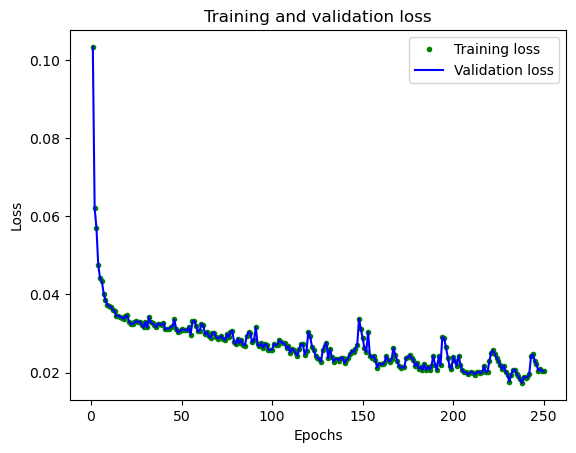

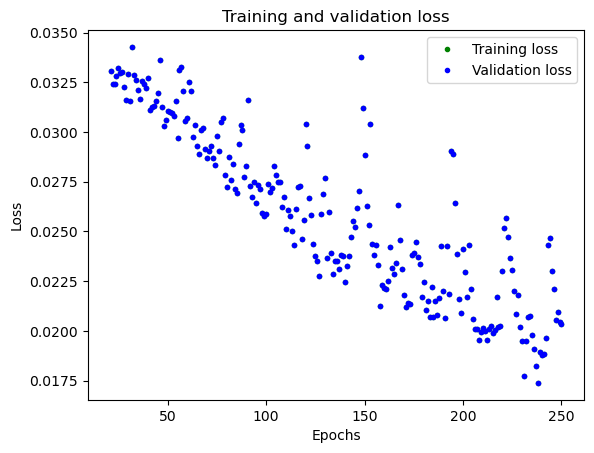

In [16]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
validation_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], validation_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
housePrices_model.save('House_prices_model')
reloaded = tf.keras.models.load_model('House_prices_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: House_prices_model\assets


In [23]:
test_features_dict = {name: np.array(value) 
                         for name, value in test.items()}




predicted_price_test_set = reloaded.predict(test_features_dict)*data_scaling

test_with_result = test.copy()
test_with_result['predicted_price'] = predicted_price_test_set

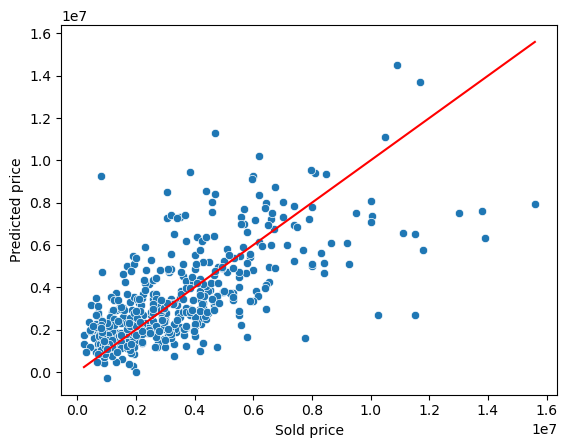

In [37]:
sns.scatterplot(x = test_with_result['sold_price'], y = test_with_result['predicted_price'])
sns.lineplot(x = test_with_result['sold_price'], y = test_with_result['sold_price'],dashes=True, color='red')

plt.xlabel('Sold price')
plt.ylabel('Predicted price')

plt.show()

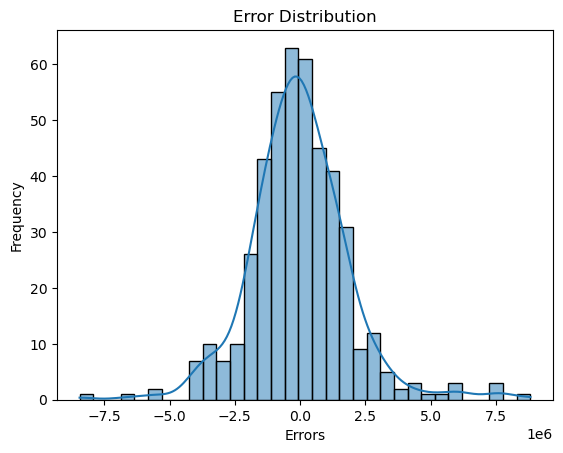

In [39]:
errors = test_with_result['sold_price'] - test_with_result['predicted_price']

# Create the histogram
sns.histplot(errors, kde=True)

# Add labels and a title
plt.xlabel('Errors')
plt.ylabel('Frequency')
plt.title('Error Distribution')

# Show the plot
plt.show()